# Creating and Training MLP
### Imports and reading

In [1]:
import os, math, time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import metrics

import tensorflow.contrib.tensorrt as trt
from tensorflow.python.platform import gfile

dataset = pd.read_csv('../data/Dataset_refined/latest_complete.csv', sep=',')
dataset = dataset.drop(['velocity'], axis=1)
X = dataset.iloc[:,0:-1].values
y = dataset.iloc[:,-1].values

MODEL_NAME = 'mlp-small.h5'

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Dataset Information

In [2]:
right_turns = y[np.where(y > 0.1)]
left_turns = y[np.where(y < -0.1)]
straight = y[np.where(abs(y) < 0.1)]
print("Training Size: ", y.shape[0])
print("Number of Straight: ", straight.shape[0])
print("Number of right turns: ", right_turns.shape[0])
print("Number of left turns: ", left_turns.shape[0])
print("max: ", np.amax(y))
print("median: ", np.median(y))
print("min: ", np.amin(y))
dataset.describe()

Training Size:  15661
Number of Straight:  7244
Number of right turns:  3458
Number of left turns:  4959
max:  0.4189000129699707
median:  -0.04473118111491203
min:  -0.4189000129699707


,0,1,2,3,4,5,6,7,8,9,...,1072,1073,1074,1075,1076,1077,1078,1079,1080,steering_angle
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,...,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,1.546074,1.532822,1.519684,1.508848,1.497069,1.484899,1.473679,1.463179,1.452031,1.442898,...,2.053130,2.069219,2.107226,2.114062,2.149911,2.198493,2.174829,2.215040,2.220438,-0.026104
std,1.057151,1.040667,1.025918,1.018475,1.009149,0.999480,0.989791,0.982666,0.976010,0.970981,...,6.127650,6.169612,6.313436,6.293725,6.434450,6.630021,6.454853,6.610371,6.589992,0.233896
min,0.295000,0.297000,0.295000,0.287000,0.286000,0.285000,0.285000,0.282000,0.280000,0.282000,...,0.416000,0.422000,0.425000,0.425000,0.427000,0.435000,0.442000,0.444000,0.442000,-0.418900
25%,0.959000,0.956000,0.951000,0.947000,0.942000,0.938000,0.934000,0.930000,0.926000,0.922000,...,0.944000,0.951000,0.957000,0.964000,0.969000,0.978000,0.985000,0.992000,1.000000,-0.134009
50%,1.250000,1.244000,1.237000,1.230000,1.221000,1.212000,1.202000,1.197000,1.190000,1.184000,...,1.232000,1.237000,1.243000,1.249000,1.254000,1.260000,1.265000,1.271000,1.279000,-0.044731
75%,1.618000,1.608000,1.597000,1.588000,1.576000,1.566000,1.557000,1.548000,1.539000,1.531000,...,1.636000,1.644000,1.656000,1.666000,1.675000,1.685000,1.694000,1.705000,1.716000,0.070258
max,8.040000,8.080000,8.132000,8.177000,8.177000,8.085000,8.122000,8.141000,8.191000,8.186000,...,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,0.418900


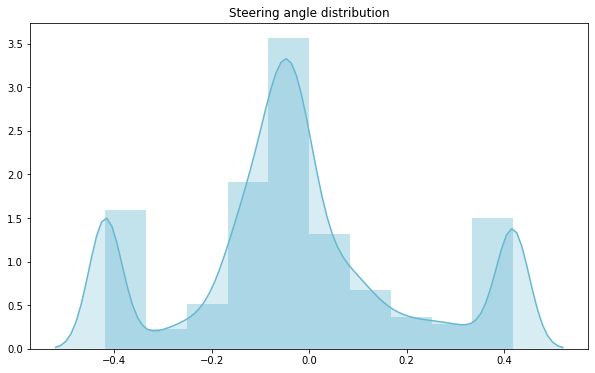

In [3]:
fig = plt.figure(figsize=(10,6))
sns.distplot(y, bins=10, hist=True, kde_kws={"shade": True}, color='#67B7D1')# green - #3cb44b, blue - #67B7D1
plt.title('Steering angle distribution', loc='center')
plt.show()

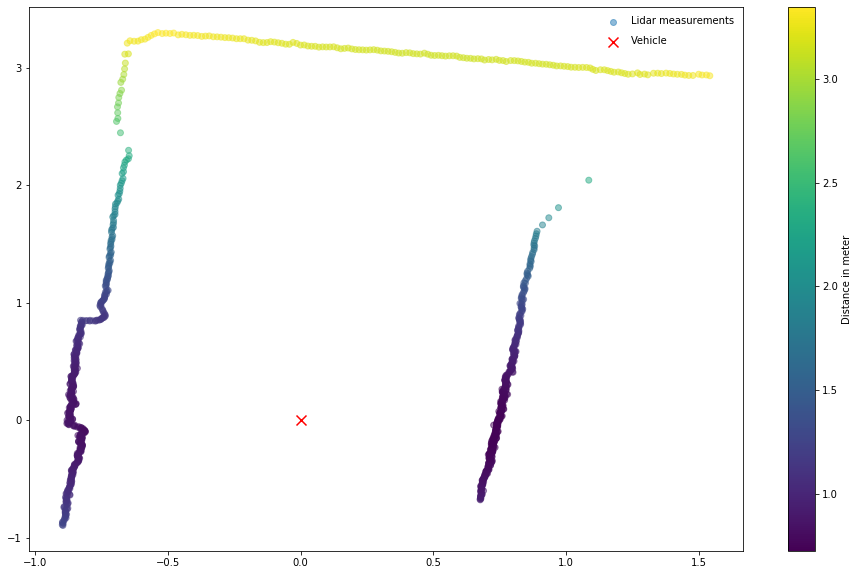

Output:  -0.108561709523201


In [4]:
angle_inc = math.radians(0.25)
angle_start = -math.radians(45)

SEQ_IDX = 500
data_plot = X[SEQ_IDX]

x_ = []
y_ = []

for i in range(len(data_plot)):
    angle = angle_start + i * angle_inc
    x_.append(data_plot[i]*math.cos(angle))
    y_.append(data_plot[i]*math.sin(angle))

norm = mpl.colors.Normalize(vmin=np.amin(data_plot), vmax=np.amax(data_plot))

fig = plt.figure(figsize=(16,10))
plt.scatter(x_,y_, c=(data_plot), cmap='viridis', marker='o', alpha=0.5, label='Lidar measurements')
plt.scatter(x=0, y=0,s=100, c='r', marker="x", label='Vehicle')
plt.axis(aspect='equal')

plt.colorbar(mpl.cm.ScalarMappable(norm=norm), label='Distance in meter')
plt.legend(labelspacing=1,frameon=False)
plt.show()
print("Output: ", y[SEQ_IDX])

### Normalize

In [5]:
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

### Create Keras Model

In [6]:
inputs = Input(shape=(360,), name="input_layer")

dense1 = Dense(32, name="dense_layer_1")(inputs)
dense1 = Activation("relu")(dense1)

dense2 = Dense(64, name="dense_layer_2")(dense1)
dense2 = Activation("relu")(dense2)

dense3 = Dense(32, name="dense_layer_3")(dense2)
dense3 = Activation("relu")(dense3)

final = Dense(1, name="output_layer")(dense3)

model = Model(inputs=inputs, outputs=final)

model.compile(loss='mean_squared_error',
              optimizer= Adam(), metrics=[metrics.mae])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 360)]             0         
_________________________________________________________________
dense_layer_1 (Dense)        (None, 32)                11552     
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 64)                2112      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_layer_3 (Dense)        (None, 32)                2080      
______________________________________________

### Preprocess input
##### Make the input smaller, limit the view and use every other measurement

In [7]:
#preproccess 45 degrees = 180 iter
def preprocess(lidar):
    new_list = []
    for i in range (180, 900):
        if(i % 2 == 0):
            new_list.append(lidar[i])
    return np.array(new_list)
    

In [8]:
processed_data = []

for x in X:
    processed_data.append(preprocess(x))

processed_data = np.array(processed_data)
x_t, x_v, y_t, y_v = train_test_split(processed_data, y, test_size=0.15, random_state=0)

15661
(15661, 360)


## Train Model

In [9]:
BATCH_SIZE = 24 
EPOCHS = 30

history = model.fit(x_t,y_t,
                    verbose=1,
                    epochs= EPOCHS,
                    validation_data=(x_v,y_v))

Train on 12528 samples, validate on 3133 samples
Epoch 1/30
12528/12528 [==============================] - 3s 210us/sample - loss: 0.0155 - mean_absolute_error: 0.0870 - val_loss: 0.0104 - val_mean_absolute_error: 0.0711
Epoch 2/30
12528/12528 [==============================] - 2s 132us/sample - loss: 0.0112 - mean_absolute_error: 0.0731 - val_loss: 0.0103 - val_mean_absolute_error: 0.0722
Epoch 3/30
12528/12528 [==============================] - 2s 142us/sample - loss: 0.0103 - mean_absolute_error: 0.0694 - val_loss: 0.0101 - val_mean_absolute_error: 0.0696
Epoch 4/30
12528/12528 [==============================] - 2s 145us/sample - loss: 0.0102 - mean_absolute_error: 0.0688 - val_loss: 0.0104 - val_mean_absolute_error: 0.0743
Epoch 5/30
12528/12528 [==============================] - 2s 150us/sample - loss: 0.0092 - mean_absolute_error: 0.0644 - val_loss: 0.0087 - val_mean_absolute_error: 0.0621
Epoch 6/30
12528/12528 [==============================] - 2s 174us/sample - loss: 0.0089 - 

### Save Keras Model

In [10]:
model.save(MODEL_NAME)

## Load Keras Model and Export to Tensorflow model

In [11]:
tf.keras.backend.set_learning_phase(0) 

MODEL_PATH = "./model/mlp-tf-small"

model = load_model('./model/mlp-small.h5')

saver = tf.train.Saver()
sess = tf.keras.backend.get_session()
save_path = saver.save(sess, MODEL_PATH)

In [12]:
#tf to TFRT
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.50))) as sess:
    saver = tf.train.import_meta_graph("./model/mlp-tf-small.meta")
    saver.restore(sess, "./model/mlp-tf-small")
    
    output_nodes = ["dense_3/BiasAdd"] #output layer
    
    # convert to frozen model
    frozen_graph = tf.compat.v1.graph_util.convert_variables_to_constants(
        sess, 
        tf.get_default_graph().as_graph_def(),
        output_node_names=output_nodes)
    
    with gfile.FastGFile("./model/frozen_model.pb", 'wb') as f:
        f.write(frozen_graph.SerializeToString())

INFO:tensorflow:Restoring parameters from ./model/mlp-tf-small
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.
Instructions for updating:
Use tf.gfile.GFile.


In [13]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_nodes,
    max_batch_size=2,# specify your max batch size
    max_workspace_size_bytes=2*(10**9),# specify the max workspace
    precision_mode="FP32") # precision, can be "FP32" (32 floating point precision) or "FP16"

with gfile.FastGFile("./model/TensorRT_model.pb", 'wb') as f:
    f.write(trt_graph.SerializeToString())

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Running against TensorRT version 0.0.0


In [14]:
# check how many ops of the original frozen model
all_nodes = len([1 for n in frozen_graph.node])
print("numb. of all_nodes in frozen graph:", all_nodes)

# check how many ops that is converted to TensorRT engine
trt_engine_nodes = len([1 for n in trt_graph.node if str(n.op) == 'TRTEngineOp'])
print("numb. of trt_engine_nodes in TensorRT graph:", trt_engine_nodes)
all_nodes = len([1 for n in trt_graph.node])
print("numb. of all_nodes in TensorRT graph:", all_nodes)

numb. of all_nodes in frozen graph: 28
numb. of trt_engine_nodes in TensorRT graph: 0
numb. of all_nodes in TensorRT graph: 20


## Prediction

In [15]:
def read_pb_graph(model):
    with gfile.FastGFile(model,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

In [17]:
import tensorflow as tf
tf.keras.backend.set_learning_phase(0) 
from tensorflow.keras.models import load_model
import tensorflow.contrib.tensorrt as trt
from tensorflow.python.platform import gfile
import numpy as np
import time

TENSORRT_MODEL_PATH = './model/TensorRT_model.pb'

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))) as sess:
        
        trt_graph = read_pb_graph(TENSORRT_MODEL_PATH)

        # obtain the corresponding input-output tensor
        tf.import_graph_def(trt_graph, name='')
        input = sess.graph.get_tensor_by_name('input_layer_1:0')
        output = sess.graph.get_tensor_by_name('output_layer:0')
        
        
        #testing with trash data
        lidar_func = lambda x : x if x <= 15.0 else 15.0
        lidar = np.array(np.random.rand(360) * 10)
        lidar = np.array([[ lidar_func(i)/15.0 for i in lidar ]])
        
        
        tot_time = 0
        for i in range(50):
            lidar = np.array(np.random.rand(360) * 10)
            lidar = np.array([[ lidar_func(i)/15.0 for i in lidar ]])
            start = time.time()
            out_pred = sess.run(output, feed_dict={input: lidar})
            end = time.time()
            tot_time = tot_time + (end-start)
            print("Prediction: ", out_pred[0],"time: ", (end-start))
        print("avg time: ", tot_time/50)

KeyError: "The name 'input_layer_1:0' refers to a Tensor which does not exist. The operation, 'input_layer_1', does not exist in the graph."